# Problem statement and domain

We want to solve the following integer optimization problem.

$$
P9 = 
\begin{array}{l l l l l}
\min & -x_1 & -x_2 \\
s.t. & -2x_1 &+2x_2& \leq 5 \\
& & 2x_2 &\leq 7 \\
& 5x_1 & + 2x_2 &\leq 26 \\
& x_1, & x_2 & \geq 0 \\
& x_1, & x_2 & \in \mathbb{Z}
\end{array}
$$

We reduce it to standard form by introducing slack variables $s_1, s_2, s_3$.

$$
P9 = 
\begin{array}{l l l l l l l}
\min & -x_1 & -x_2 \\
s.t. & -2x_1 & +2x_2 & + s_1 & &  &= 5 \\
     &       & 2x_2  &      & +s_2 & &= 7 \\
     & 5x_1  & + 2x_2 &     &     & +s_3 &  = 26 \\
& x_1, & x_2, &  s_1,      &  s_2,   &  s_3   &      \geq 0 \\
& x_1, & x_2 &        &     &     &      \in \mathbb{Z}
\end{array}
$$

We plot the feasible region, the possible integer solutions in it and their convex hull.

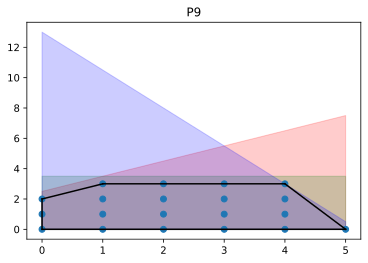

In [175]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull


def plot_constraints(constraints, x_max = 5, title = "P9"):
    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
    x1 = np.linspace(0, x_max)
    for i, c in enumerate(constraints):
        plt.fill_between(x1, c(x1), color=colors[i], alpha = 0.2)
        x_int = np.array(range(x_max + 1))
    x1_int, x2_int = np.meshgrid(x_int, x_int)
    zipped = zip(x1_int.flatten().tolist(),x2_int.flatten().tolist())
    couples = [(x1, x2) for (x1, x2) in zipped if all([x2 <= c(x1) for c in constraints])]
    couples = np.array(couples)
    hull = ConvexHull(couples)
    for simplex in hull.simplices:
        plt.plot(couples[simplex, 0], couples[simplex, 1], 'k-')
    # Plot integer points inside
    plt.scatter(*zip(*couples))
    plt.title(title)
    
    
c1 = lambda x1 : 5/2 + x1
c2 = lambda x1 : 7/2
c3 = lambda x1 : 13 - 5/2 * x1

plot_constraints([c1, c2, c3])

Graphically, we can see that the optimal solution to the problem is $f(4, 3) = -7$. We indicate this in red in the following plot.

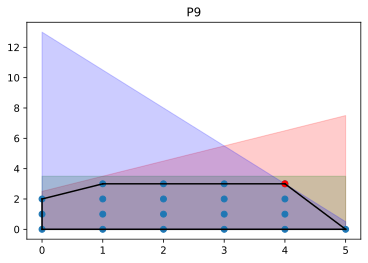

In [265]:
plot_constraints([c1, c2, c3])
plt.scatter(4, 3, color='r');

# Linear relaxation and lower bound

The linear relaxation of the problem removes the integrality constraint from $x_1, x_2$, i.e. the problem in standard form becomes:

$$
LP(P9) = 
\begin{array}{l l l l l l l}
\min & -x_1 & -x_2 \\
s.t. & -2x_1 & +2x_2 & + s_1 & &  &= 5 \\
     &       & 2x_2  &      & +s_2 & &= 7 \\
     & 5x_1  & + 2x_2 &     &     & +s_3 &  = 26 \\
& x_1, & x_2, &  s_1,      &  s_2,   &  s_3   &      \geq 0 \\
\end{array}
$$

We solve the linear relaxation of the problem using CPLEX and the following AMPL model (file `P9.mod`):

```
var x1 >=0;
var x2 >=0;


minimize P9:
-x1 -x2;

subject to c1: -2 * x1 +2 * x2 <= 5;
subject to c2: 2 * x2 <= 7;
subject to c3: 5 * x1 + 2 * x2 <= 26;
```

We run the following AMPL code (file `P9.run`):
```
reset;
model P9.mod;
option solver cplex;

option presolve 0;
option cplex_options ('timing 1 mipdisplay 5 mipinterval 1' &
                      'presolve 0 mipcuts -1 cutpass -1 ' &
                      'heurfreq -1 endbasis 1 display 2 primal');
                      
solve;

display x1, x2;
```

We get the following output:

```
CPLEX 20.1.0.0: timing 1
mipdisplay 5
mipinterval 1
presolve 0
mipcuts -1
cutpass -1
heurfreq -1
endbasis 1
display 2

Iteration      Dual Objective            In Variable           Out Variable
     1  I            0.000000                     x2               c3 slack
     2              -8.500000                     x1               c1 slack
     3              -7.300000               c1 slack               c2 slack

Times (seconds):
Input =  0.001024
Solve =  0.001417
Output = 0.001185
CPLEX 20.1.0.0: optimal solution; objective -7.3
3 dual simplex iterations (1 in phase I)
x1 = 3.8
x2 = 3.5
```

We find that the optimal solution is $f(\frac{19}{5}, \frac{7}{2}) = -\frac{73}{10}$.

Its associated lower bound is $L_0 = -\lfloor\frac{73}{10}\rfloor = -7$.

We plot this solution over the previous plot.

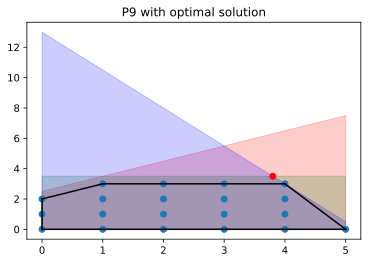

In [254]:
plot_constraints([c1, c2, c3], title="P9 with optimal solution")
plt.scatter(19/5, 7/2, color='r');


# Branch and bound

We let CPLEX solve the problem by branch and bound, introducing the integrality constraint.
To do so, we modify the model as follows:

```
var x1 >=0, integer;
var x2 >=0, integer;


minimize P9:
-x1 -x2;

subject to c1: -2 * x1 +2 * x2 <= 5;
subject to c2: 2 * x2 <= 7;
subject to c3: 5 * x1 + 2 * x2 <= 26;

```

while the `.run` file stays unchanged. We get the following output:
```
CPLEX 20.1.0.0: timing 1
mipdisplay 5
mipinterval 1
presolve 0
mipcuts -1
cutpass -1
heurfreq -1
endbasis 1
display 2
primal
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.

Iteration      Dual Objective            In Variable           Out Variable
     1  I            0.000000                     x1               c3 slack
Root relaxation solution time = 0.00 sec. (0.00 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0       -7.0000       -7.0000        1    0.00%
Elapsed time = 0.00 sec. (0.00 ticks, tree = 0.00 MB)
Found incumbent of value -7.000000 after 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Using steepest-edge.

Times (seconds):
Input =  0.001318
Solve =  0.003298
Output = 0.001179
CPLEX 20.1.0.0: optimal integer solution; objective -7
1 MIP simplex iterations
0 branch-and-bound nodes
x1 = 4
x2 = 3
```


We see that, thanks to the optimizations in the AMPL implementation of CPLEX, the solver directly finds the optimal solution $f(4, 3) = -7$. Nevertheless, we now have a baseline to compare our solutions.

Therefore, we perform branch and bound by hand, using CPLEX to help solve the subproblems.

We choose first the branching variable. Our criterion is to branch on the largest non-integer variable, that is $x_1 = \frac{19}{5}$, thus defining two subproblems: $P9 \land x_1 \geq 4$ and $P9 \land x_1 \leq 3$.
The first subproblem is:

$$
\begin{array}{l l l l l}
\min & -x_1 & -x_2 \\
s.t. & -2x_1 &+2x_2& \leq 5 \\
& & 2x_2 &\leq 7 \\
& 5x_1 & + 2x_2 &\leq 26 \\
& -x_1 & &\leq -4 \\
& x_1, & x_2 & \geq 0 \\
\end{array}
$$

and the second subproblem is:

$$
\begin{array}{l l l l l}
\min & -x_1 & -x_2 \\
s.t. & -2x_1 &+2x_2& \leq 5 \\
&  & 2x_2 &\leq 7 \\
& 5x_1 & + 2x_2 &\leq 26 \\
& x_1 & &\leq 3 \\
& x_1, & x_2 & \geq 0 \\
\end{array}
$$

These inequalities, together with the constraint $2x_2 \leq 7$, allow us to define upper and lower bounds for the two subproblems.

The first subproblem has $x_2 \leq \lfloor \frac{7}{2} \rfloor \implies x_2 \leq 3$ and $x_1 \geq 4$, therefore an upper bound for the solution is $U_1 = f(4, 0) = -4$ while its lower bound is equal to the one of the parent problem, that is $L_1 = L_0 = -7$.

The second subproblem has $x_2 \leq 3$, $x_1 \leq 3$, therefore its upper bound is $U_2 = f(0, 0) = 0$ and its lower bound is $L_2 = f(3, 3) = -6$.

We plot both subproblems over the previous plot. The first one is in magenta, while the second is in green.

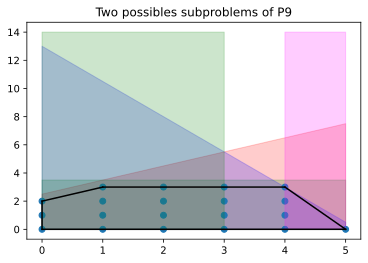

In [257]:
plot_constraints([c1, c2, c3], title="Two possibles subproblems of P9");
plt.fill([4, 4, 5, 5], [0, 14, 14, 0], alpha=0.2, color = 'magenta');
plt.fill([0, 0, 3, 3], [0, 14, 14, 0], alpha=0.2, color = 'green');


We choose to solve with CPLEX the first subproblem, since its lower bound is better.
We therefore modify the model file as such:

```
var x1 >=0;
var x2 >=0;


minimize P9:
-x1 -x2;

subject to c1: -2 * x1 +2 * x2 <= 5;
subject to c2: 2 * x2 <= 7;
subject to c3: 5 * x1 + 2 * x2 <= 26;
subject to branch1: x1 >= 4;
```

We get the following output:
```
CPLEX 20.1.0.0: timing 1
mipdisplay 5
mipinterval 1
presolve 0
endbasis 1
display 2
lbheur 0
mipsearch 1
mipstartvalue 0
mipstartstatus 0

Iteration      Dual Objective            In Variable           Out Variable
     1  I            0.000000                     x2               c3 slack
     2              -8.500000                     x1               c1 slack
     3              -7.300000               c1 slack               c2 slack
     4              -7.000000               c2 slack               c4 slack

Times (seconds):
Input =  0.001335
Solve =  0.000901
Output = 0.001778
CPLEX 20.1.0.0: optimal solution; objective -7
4 dual simplex iterations (1 in phase I)
x1 = 4
x2 = 3
```

We get the integer solution $f(4, 3) = -7$, which is equal to the lower bound previously obtained, therefore we stop here and eliminate the other subproblem.
We obtain the following enumeration tree:

<img src="Enumeration_tree.png" alt="Enumeration tree" width="40%"/>

We now plot graphically this solution over the previous plot.

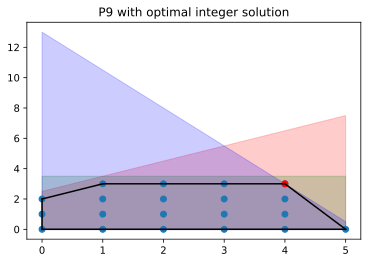

In [255]:
plot_constraints([c1, c2, c3], title="P9 with optimal integer solution")
plt.scatter(4, 3, color='r');

# Gomory cuts

The $i$-th row of the optimal tableau of the problem in standard form is expressed by:

$$x_{B_i} + \sum_j t_{ij}x_{N_j} = b^*_i$$

In this expression $x_{B_i}$ are the basic variables, $x_{N_j}$ are the non-basic variables and $t_{ij}$ is the multiplicative coefficient for non-basic variable $j$ in the $i$-th row.

A Gomory cutting plane (Gilmore and Gomory 1961) is expressed by:

$$\sum_j (t_{ij} - \lfloor t_{ij} \rfloor) x_{N_j} \geq b^*_i - \lfloor b^*_i \rfloor$$

This is guaranteed to be a valid cut of the LP relaxation of an integer programming problem.

We use the following Python code, leveraging the Python implementation of CPLEX, to get the final tableau. We formulate the problem in standard form, with explicit slack variables, then we let CPLEX solve it and extract the final tableau, as well as the final right-hand-side vector $b^* = B^{-1} b$.
Finally, we count the number of possible cuts, leveraging the fact that one cut can be generated for each variable (whether it is a slack variable or not) that has a fractional value in the final solution.

In [272]:
import cplex
import fractions

def print_solution(prob, is_integer = False):
    ncol = len(prob.variables.get_cols())
    nrow = len(prob.linear_constraints.get_rows())
    varnames = prob.variables.get_names()
    # solution.get_status() returns an integer code
    print('Solution status = ' , prob.solution.get_status(), ':')
    # the following line prints the corresponding string
    print(prob.solution.status[prob.solution.get_status()])
    print('Solution value  = ', prob.solution.get_objective_value())
    slack = np.round(prob.solution.get_linear_slacks(), 3)
    x     = np.round(prob.solution.get_values(), 3)
    for i in range(nrow):
        print(f'Row {i}:  Slack = {slack[i]}')
    for j in range(ncol):
        print(f'Column {j} (variable {varnames[j]}):  Value = {x[j]}')

    
def get_p9(is_integer = False, is_standard = True):
    f      = [-1, -1, 0, 0, 0]
    varnames = ['x1', 'x2', 's1', 's2', 's3']
    b      = [5, 7, 26]
    rownames = ['c1', 'c2', 'c3']
    sense    = 'EEE'
    if is_integer:
        types = 'IICCC'
    else:
        types = 'CCCCC'
    rows = [[['x1','x2', 's1', 's2', 's3'],[-2, 2, 1, 0, 0]],
            [[0, 1, 2, 3, 4],[ 0, 2, 0, 1, 0]],
            [[0, 1, 2, 3, 4],[ 5, 2, 0, 0, 1]]]
    if not is_standard:
        true_vars = np.nonzero(f)[0]
        true_vars = true_vars.shape[0]
        f = f[:true_vars]
        varnames = varnames[:true_vars]
        types = types[:true_vars]
        rows = [[a[:true_vars], b[:true_vars]] for a, b in rows]
        sense = 'LLL'        
    nrow = len(rownames)
    ncol = len(varnames)
    prob = cplex.Cplex()
    if is_integer:
        prob.variables.add(obj = f, names = varnames, types = types)
    else:
        prob.variables.add(obj = f, names = varnames)
    prob.linear_constraints.add(lin_expr = rows, senses = sense,
                                rhs = b, names = rownames)
    prob.objective.set_sense(prob.objective.sense.minimize)
    prob.parameters.preprocessing.presolve.set(0)
    return prob


def print_final_tableau(prob):
    BinvA = np.array(prob.solution.advanced.binvarow())

    nrow = BinvA.shape[0]
    ncol = BinvA.shape[1]
    b_bar = np.zeros(nrow)
    varnames = prob.variables.get_names()
    b = prob.linear_constraints.get_rhs()
    Binv = np.array(prob.solution.advanced.binvrow())
    b_bar = np.matmul(Binv, b)


    print('\n\nFinal tableau:')
    idx = 0     # Compute the nonzeros
    n_cuts = 0  # Number of fractional variables (cuts to be generated)
    for i in range(nrow):
        z = prob.solution.advanced.binvarow(i)
        for j in range(ncol):
            if z[j] > 0:
                print('+', end='')
            zj = fractions.Fraction(z[j]).limit_denominator()
            num = zj.numerator
            den = zj.denominator
            if num != 0 and num != den:
                print(f'{num}/{den} {varnames[j]} ', end='')
            elif num == den:
                print(f'{varnames[j]} ', end='')
            if np.floor(z[j]+0.5) != 0:
                idx += 1
        b_bar_i = fractions.Fraction(b_bar[i]).limit_denominator()
        num = b_bar_i.numerator
        den = b_bar_i.denominator
        print(f'= {num}/{den}\n')
        # Count the number of cuts to be generated
        if np.floor(b_bar[i]) != b_bar[i]:
            n_cuts += 1    
    print(f'Cuts to generate: {n_cuts}')
    return BinvA

prob = get_p9()

prob.solve()
print_solution(prob)

print_final_tableau(prob);

Version identifier: 20.1.0.0 | 2020-11-11 | 9bedb6d68
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual infeasibility =             0.000000
Iteration:     2   Dual objective     =            -8.500000
Solution status =  1 :
optimal
Solution value  =  -7.300000000000001
Row 0:  Slack = 0.0
Row 1:  Slack = 0.0
Row 2:  Slack = 0.0
Column 0 (variable x1):  Value = 3.8
Column 1 (variable x2):  Value = 3.5
Column 2 (variable s1):  Value = 5.6
Column 3 (variable s2):  Value = 0.0
Column 4 (variable s3):  Value = 0.0


Final tableau:
+x1 -1/5 s2 +1/5 s3 = 19/5

+s1 -7/5 s2 +2/5 s3 = 28/5

+x2 +1/2 s2 = 7/2

Cuts to generate: 3


The final tableau is therefore:

$$
\begin{array}{l l l l l l l}
x_1 & &  & - \frac{1}{5} s_2& + \frac{1}{5} s_3 &= \frac{19}{5} \\
&   &  s_1    & -\frac{7}{5}s_2 & +\frac{2}{5} s_3&= \frac{28}{5} \\
& x_2 &     &  +\frac{1}{2} s_2   & &  = \frac{7}{2} \\
\end{array}
$$


There are 3 possible cuts, which we now generate.

In [281]:
import fractions
gc_sense = [''] * n_cuts
gc_rhs   = np.zeros(n_cuts)
gc_lhs   = np.zeros([n_cuts, ncol])
rmatbeg  = np.zeros(n_cuts)
rmatind  = np.zeros(ncol)
rmatval  = np.zeros(ncol)
print('\nGenerated Gomory cuts:\n')
idx = 0
cut = 0  #  Index of cut to be added
for i in range(nrow):
    if np.floor(b_bar[i]) != b_bar[i]:
        print(f'Row {i+1} gives cut -> ', end = '')
        z = np.copy(prob.solution.advanced.binvarow(i)) # Use np.copy to avoid changing the
                                                        # optimal tableau in the problem instance
        rmatbeg[cut] = idx;
        for j in range(ncol):
            z[j] = z[j] - np.floor(z[j])              
            if z[j] != 0:
                rmatind[idx] = j
                rmatval[idx] = z[j]
                idx +=1
            
            # Print the cut
            if z[j] > 0:
                print('+', end = '')
            if (z[j] != 0):
                fj = fractions.Fraction(z[j])
                fj = fj.limit_denominator()
                num, den = (fj.numerator, fj.denominator)
                print(f'{num}/{den} {varnames[j]} ', end='')
            gc_lhs[i,:] = z
    
        gc_rhs[cut] = b_bar[i] - np.copy(np.floor(b_bar[i])) # np.copy as above
        gc_sense[cut] = 'L'
        gc_rhs_i = fractions.Fraction(gc_rhs[cut]).limit_denominator()
        num = gc_rhs_i.numerator
        den = gc_rhs_i.denominator
        print(f'>= {num}/{den}\n')
        cut += 1


Generated Gomory cuts:

Row 1 gives cut -> +4/5 s2 +1/5 s3 >= 4/5

Row 2 gives cut -> +3/5 s2 +2/5 s3 >= 3/5

Row 3 gives cut -> +1/2 s2 >= 1/2



We see that the cuts that can be generated are:

$$
\begin{array}{l l l l}
\frac{4}{5}s_2 & + \frac{1}{5}s_3 & \geq \frac{4}{5} \\
\frac{3}{5}s_2 & + \frac{2}{5}s_3 & \geq \frac{3}{5} \\
\frac{1}{2}s_2 &  \               & \geq \frac{1}{2}
\end{array}
$$

To draw them graphically, we leverage the initial tableau, which contains a solution with only slack variables in the basis, in a useful configuration: row $i$ is of the form $c_{i1} x_1 + c_{i2} x_2 + s_i = b_i$.

In each cut, for each slack variable $s_k$, we take its coefficient $c_k$ in the Gomory cut and subtract the corresponding row of the initial tableau multiplied by $c_k$. Since the coefficient of the slack is 1 in each row, this will eliminate the slacks and result in a constraint expressed only in terms of $x_1, x_2$, which we plot below.



Gomory cuts:
+1.0 x1 +2.0 x2 <= 10.0
+2.0 x1 +2.0 x2 <= 14.0
+1.0 x2 <= 3.0


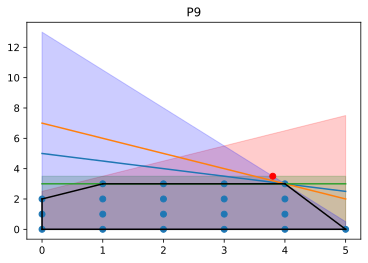

In [259]:
def get_A_matrix(prob):
    rows = prob.linear_constraints.get_rows()
    nrow = len(rows)
    ncol = max([max(r.ind) for r in rows]) + 1

    A = np.zeros((nrow, ncol))
    for i, r in enumerate(prob.linear_constraints.get_rows()):
        for j in range(ncol):
            if j in r.ind:
                A[i, j] = r.val[r.ind.index(j)]
    return A



def get_plottable_cut(prob, cut_row, cut_rhs, A):
    cut_row = np.append(cut_row, cut_rhs)
    b = np.array(prob.linear_constraints.get_rhs())
    A = np.append(A, b.reshape(-1, 1), axis=1)
    plotted_vars = np.nonzero(prob.objective.get_linear())[0]
    # Assumption: plotted variables are at the beginning of the initial tableau
    for i, sk in enumerate(range(len(plotted_vars), ncol)):
        cut_coef = cut_row[sk]
        cut_row -= A[i,:] * cut_coef
    lhs = cut_row[:len(plotted_vars)]
    rhs = cut_row[ncol:]
    return lhs, rhs

prob = get_p9()
A = get_A_matrix(prob)
print('\nGomory cuts:')
for i, gc in enumerate(gc_lhs):
    lhs, rhs = get_plottable_cut(prob, gc_lhs[i], gc_rhs[i], A)
    m = -lhs[0] / lhs[1]
    q = rhs / lhs[1]
    x1 = np.linspace(0, 5)
    x2 = m * x1 + q
    # Print the cut
    for j in range(len(lhs)):
        if -lhs[j] > 0:
            print('+', end = '')
        if (-lhs[j] != 0):
            print(f'{-lhs[j]} {varnames[j]} ', end='')
    print(f'<= {-rhs[0]}\n', end='')
    
    plt.plot(x1, x2)

plot_constraints([c1, c2, c3])
plt.scatter(19/5, 7/2, color='r');


The three cuts therefore have the form

$$
\begin{array}{l l l}
x_1   & + 2 x_2 & \leq 10 \\
2 x_1 & + 2 x_2 & \leq 14 \\
      & x_2 & \leq 3
\end{array}
$$

We can see from the plot that all three cuts eliminate the optimal solution of the linear relaxation from the set of feasible solutions.

We choose to add the cut $x_1 + 2 x_2 \leq 10$ and reoptimize.
We therefore modify our model file as follows:

```
var x1 >=0;
var x2 >=0;


minimize P9:
-x1 -x2;

subject to c1: -2 * x1 +2 * x2 <= 5;
subject to c2: 2 * x2 <= 7;
subject to c3: 5 * x1 + 2 * x2 <= 26;
subject to gomory1: x1 + 2 * x2 <= 10;

```

and get the following AMPL output:

```
CPLEX 20.1.0.0: timing 1
mipdisplay 5
mipinterval 1
presolve 0
endbasis 1
display 2
lbheur 0
mipsearch 1
mipstartvalue 0
mipstartstatus 0

Iteration      Dual Objective            In Variable           Out Variable
     1  I            0.000000                     x2               c3 slack
     2              -8.500000                     x1               c1 slack
     3              -7.000000               c1 slack               c4 slack

Times (seconds):
Input =  0.001069
Solve =  0.00087
Output = 0.000946
CPLEX 20.1.0.0: optimal solution; objective -7
3 dual simplex iterations (1 in phase I)
x1 = 4
x2 = 3
```
We get the solution $f(4, 3) = -7$ which we know to be optimal since it coincides with the lower bound we calculated before, when performing branch and bound.

# Chvàtal‐Gomory inequalities

Recall the linear relaxation of the problem, without slack variables:

$$
LP(P9) = 
\begin{array}{l l l l l}
\min & -x_1 & -x_2 \\
s.t. & -2x_1 &+2x_2& \leq 5 \\
& & 2x_2 &\leq 7 \\
& 5x_1 & + 2x_2 &\leq 26 \\
& x_1, & x_2 & \geq 0
\end{array}
$$

A Chvátal-Gomory inequality (Gomory 1958, Chvátal 1973) can be expressed as:

$$\sum_{j = 1}^n \lfloor ua_j\rfloor x_j \leq \lfloor ub \rfloor $$

where $n$ is the number of constraints, $a_j$ contains the coefficients of variable $x_j$ in the initial formulation (i.e. $a_j$ the $j$-th column of matrix $A$ if the problem is formulated as $Ax \leq b$), $u \in \mathbb{R}^m_+$ and juxtaposition denotes dot product.

From the literature (Caprara and Fischetti 1996, Koster et al. 2009) we know that a particularly useful set of Chvátal-Gomory inequalities is the one composed by inequalities with only 0 and $\frac{1}{2}$ in the $u$ vector, i.e. $u = \{0, \frac{1}{2}\}^m$. Therefore, we try and pick $u = (0, \frac{1}{2}, 0)$ and calculate the corresponding Chvátal-Gomory inequality.

In [262]:
prob = get_p9(is_standard = False)
A = get_A_matrix(prob) 
b = prob.linear_constraints.get_rhs()
u = np.array([0, 1/2, 0])
A = np.append(a1.reshape(-1, 1), a2.reshape(-1, 1), axis =1)
uTA = np.matmul(u, A)
uTb = np.matmul(u, b)

uTA = np.floor(uTA)
uTb = np.floor(uTb)

print(f'\nChvátal-Gomory inequality, u = {u}:')

for i, c in enumerate(uTA):
    if c > 0:
        print('+', end='')
    ci = fractions.Fraction(c).limit_denominator()
    num = ci.numerator
    den = ci.denominator
    if num != 0 and num != den:
        print(f'{num}/{den} x{i+1} ', end='')
    elif num == den:
        print(f'x{i+1} ', end='')
print(f' <= {uTb}')



Chvátal-Gomory inequality, u = [0.  0.5 0. ]:
+x2  <= 3.0


We get the cut $x_2 \leq 3$, which is shown in the next plot over the LP constraints.

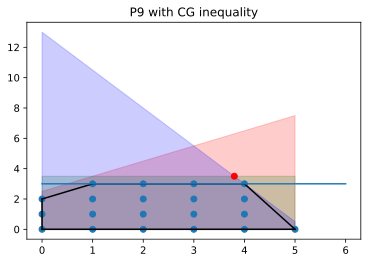

In [263]:
x1 = np.linspace(0, 6)
m = -uTA[0] / uTA[1]
q = uTb / uTA[1]
x2 = m * x1 + q
plot_constraints([c1, c2, c3], title="P9 with CG inequality")
plt.plot(x1, x2)
plt.scatter(19/5, 7/2, color='r');

We can see that this CG inequality is a valid cut, as it manages to:

- exclude the optimal LP solution
- not exclude any integer solution

In fact, comparing this inequality with the Gomory cuts obtained in the previous section, we see that this cut coincides with one of them. This is expected, as the derivation of the Gomory cuts is precisely that they are a particular Chvátal-Gomory inequality where the vector $u$ is one of the rows of the inverse of the basis matrix $B^{-1}$ obtained from the optimal tableau of the linear relaxation of the ILP (Gilmore and Gomory 1961).

We verify this by letting CPLEX solve the problem and then extract the final tableau.

In [253]:
prob = get_p9(is_standard = False)
prob.solve();
Binv = prob.solution.advanced.binvrow()
print('\nMatrix B^-1:')
print(Binv)

Version identifier: 20.1.0.0 | 2020-11-11 | 9bedb6d68
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1

Iteration log . . .
Iteration:     1   Dual infeasibility =             0.000000
Iteration:     2   Dual objective     =            -8.500000

Matrix B^-1:
[[ 0.  -0.2  0.2]
 [ 1.  -1.4  0.4]
 [ 0.   0.5  0. ]]


We can see that the inverse of the basis matrix is 

$$
B^{-1} = 
\begin{pmatrix} 
0 & -\frac{1}{5} & \frac{1}{5} \\
1 & -\frac{7}{5} & \frac{2}{5} \\
0 & \frac{1}{2} & 0
\end{pmatrix}
$$

and its third row is our vector $u$.

Finally, we add this constraint to the problem and re-optimize, getting the following model file:

```
var x1 >=0;
var x2 >=0;

minimize P9:
-x1 -x2;

subject to c1: -2 * x1 +2 * x2 <= 5;
subject to c2: 2 * x2 <= 7;
subject to c3: 5 * x1 + 2 * x2 <= 26;
subject to chvatalgomory1: x2 <= 3;
```

Which results in the following output:

```
CPLEX 20.1.0.0: timing 1
mipdisplay 5
mipinterval 1
presolve 0
endbasis 1
display 2
lbheur 0
mipsearch 1
mipstartvalue 0
mipstartstatus 0

Iteration      Dual Objective            In Variable           Out Variable
     1  I            0.000000                     x2               c3 slack
     2              -8.500000                     x1               c1 slack
     3              -7.300000               c1 slack               c2 slack
     4              -7.000000               c2 slack               c4 slack

Times (seconds):
Input =  0.001045
Solve =  0.000568
Output = 0.000948
CPLEX 20.1.0.0: optimal solution; objective -7
4 dual simplex iterations (1 in phase I)
x1 = 4
x2 = 3
```

As before, the solution obtained is $f(4, 3) = -7$ which is optimal and integer.



# References

Caprara, A., Fischetti, M. $\{0,\frac{1}{2}\}$-Chvátal-Gomory cuts. Mathematical Programming 74, 221–235 (1996). https://doi.org/10.1007/BF02592196

Koster, A.M.C.A., Zymolka, A. & Kutschka, M. Algorithms to Separate $\{0,\frac{1}{2}\}$-Chvátal-Gomory Cuts. Algorithmica 55, 375–391 (2009). https://doi.org/10.1007/s00453-008-9218-7

Gilmore, P.C, Gomory, Ralph E. A linear programming approach to the cutting stock problem. Operations Research 9, 849–859 (1961).

V. Chvátal, Edmonds polytopes and a hierarchy of combinatorial problems. Discrete Mathematics, 4-4, 305-337 (1973).

R.E. Gomory, Outline of an Algorithm for Integer Solutions to Linear Programs, Bulletin Of the American Mathematical Society 64, 275–278 (1958).

